# Import

In [1]:
# Some imports 
from transformers import (
    RobertaConfig,
    RobertaTokenizer,
    RobertaForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)
from torch.utils.data import DataLoader

import numpy as np
import torch
from datasets import load_dataset,Dataset, DatasetDict
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import umap
from scipy.spatial.distance import cosine
import blosum as bl
from datasets import load_from_disk
import tensorflow as tf
import re


c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialise the tokeniser
tokenizer = RobertaTokenizer.from_pretrained(
    "C:/Users/omala/OneDrive/Bureau/Imperial/Project/code/antibody-tokenizer/",
)

# Initialise the data collator, which is necessary for batching
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)
torch.manual_seed(42)

In [4]:
model_large = RobertaForMaskedLM.from_pretrained(
    "D:/Thesis/antiberta_large"
)
model_large.config.output_hidden_states = True
model_medium = RobertaForMaskedLM.from_pretrained(
    "D:/Thesis/antiberta_medium"
)
model_medium.config.output_hidden_states = True
model_small = RobertaForMaskedLM.from_pretrained(
    "D:/Thesis/antiberta_small"
)
model_small.config.output_hidden_states = True
model = {"large":model_large, "medium":model_medium, "small":model_small}

In [5]:

tokenized_dataset = load_from_disk("D:/Thesis/antibody_tokenized_dataset12")

# Loss function evolution :


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Small model training took 4 hours, 8 minutes, and 8.16 seconds.
Medium model training took 20 hours, 13 minutes, and 28.27 seconds.
Large model training took 39 hours, 30 minutes, and 49.44 seconds.


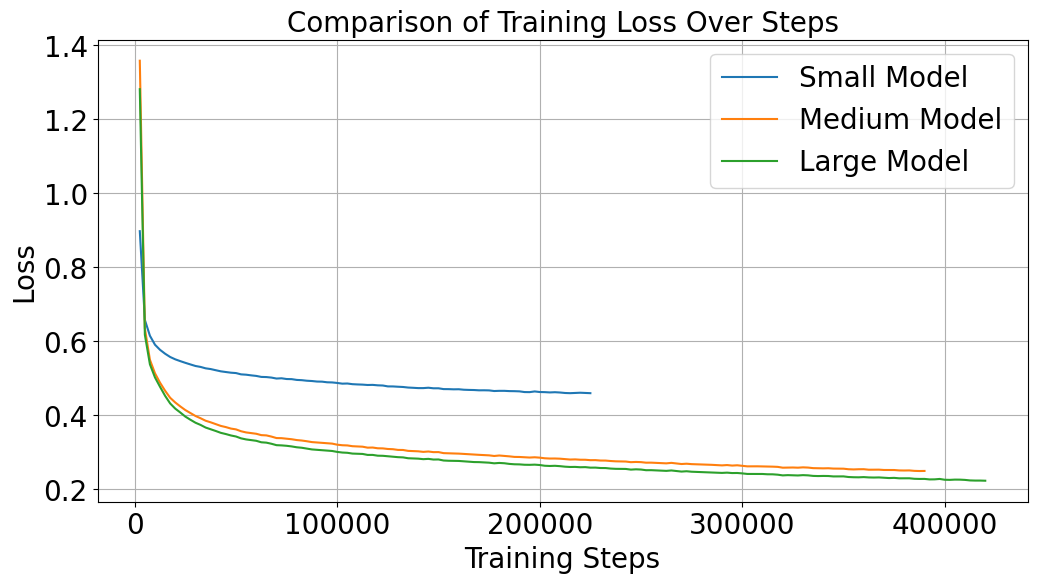

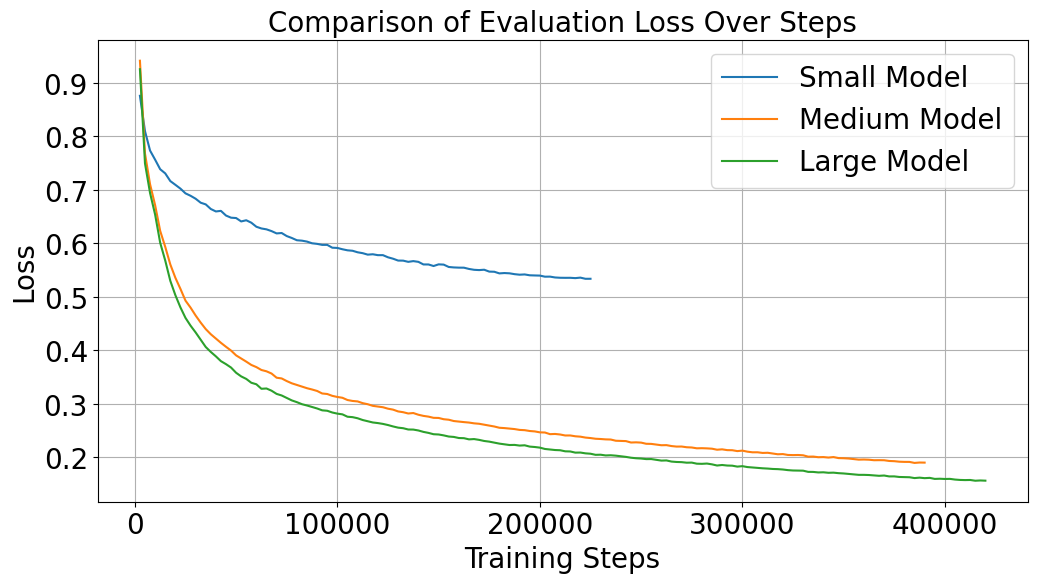

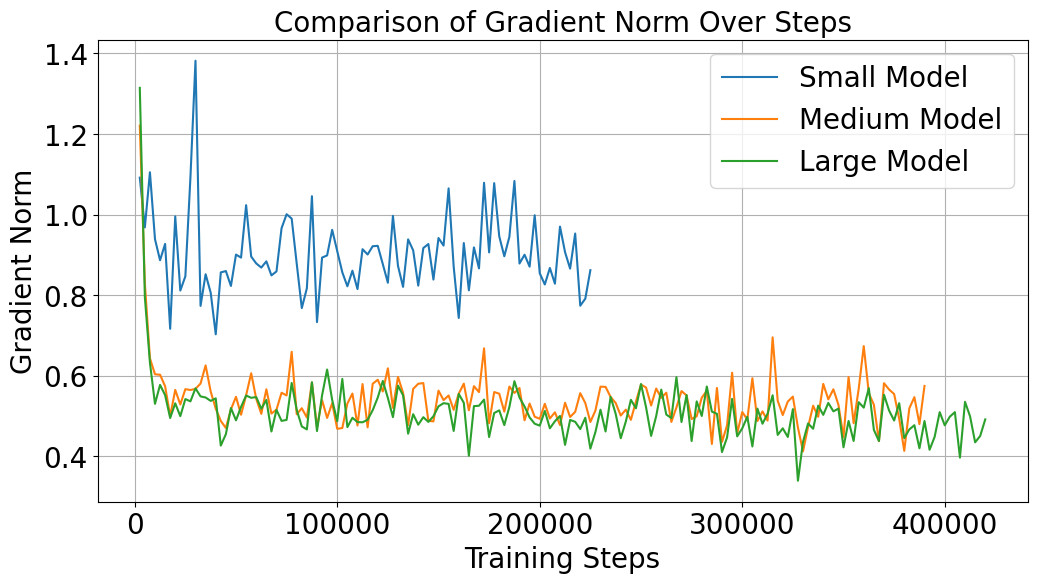

In [2]:


# Paths to the log directories for different model sizes
log_dirs = {
    'small': 'D:/Thesis/script_small_logs',
    'medium': 'D:/Thesis/script_medium_logs',
    'large': 'D:/Thesis/script_large_logs'
}

# Initialize dictionaries to hold metrics for each model
metrics = {
    'small': {'train_steps': [], 'train_losses': [], 'eval_steps': [], 'eval_losses': [], 'grad_norm': [],  'runtime': []},
    'medium': {'train_steps': [], 'train_losses': [], 'eval_steps': [], 'eval_losses': [], 'grad_norm': [],  'runtime': []},
    'large': {'train_steps': [], 'train_losses': [], 'eval_steps': [], 'eval_losses': [], 'grad_norm': [],  'runtime': []}
}

# Function to process logs and extract metrics
def process_logs(log_dir, model_size):
    for file_name in os.listdir(log_dir):
        file_path = os.path.join(log_dir, file_name)
        
        # Check if the file is an event file
        if file_name.startswith("events.out.tfevents"):
            # Iterate over the events in the file
            for event in tf.compat.v1.train.summary_iterator(file_path):
                metrics[model_size]['runtime'].append(event.wall_time)
                for value in event.summary.value:
                    if value.tag.lower() == "train/loss":
                        metrics[model_size]['train_steps'].append(event.step)
                        metrics[model_size]['train_losses'].append(value.simple_value)
                    elif value.tag.lower() == "eval/loss":
                        metrics[model_size]['eval_steps'].append(event.step)
                        metrics[model_size]['eval_losses'].append(value.simple_value)
                    elif value.tag.lower() == "train/grad_norm":
                        metrics[model_size]['grad_norm'].append(value.simple_value)
                    
    # Calculate total runtime
    runtime = metrics[model_size]['runtime'][-1] - metrics[model_size]['runtime'][0]
    hours = int(runtime // 3600)
    remaining_seconds = runtime % 3600
    minutes = int(remaining_seconds // 60)
    seconds = remaining_seconds % 60
    print(f"{model_size.capitalize()} model training took {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")

# Process logs for each model size
for model_size, log_dir in log_dirs.items():
    process_logs(log_dir, model_size)

# Plotting function to compare metrics
def plot_metrics(metric_name, ylabel, title):
    plt.figure(figsize=(12, 6))
    for model_size in metrics:
        if len(metrics[model_size][metric_name]) > 0:
            steps = metrics[model_size]['train_steps'] if 'train' in metric_name else metrics[model_size]['eval_steps']
            plt.plot(steps, metrics[model_size][metric_name], label=f"{model_size.capitalize()} Model")
    plt.xlabel('Training Steps', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.show()

# Plot comparison for each metric
plot_metrics('train_losses', 'Loss', 'Comparison of Training Loss Over Steps')
plot_metrics('eval_losses', 'Loss', 'Comparison of Evaluation Loss Over Steps')
plot_metrics('grad_norm', 'Gradient Norm', 'Comparison of Gradient Norm Over Steps')


Training took 20 hours, 33 minutes, and 13.58 seconds.


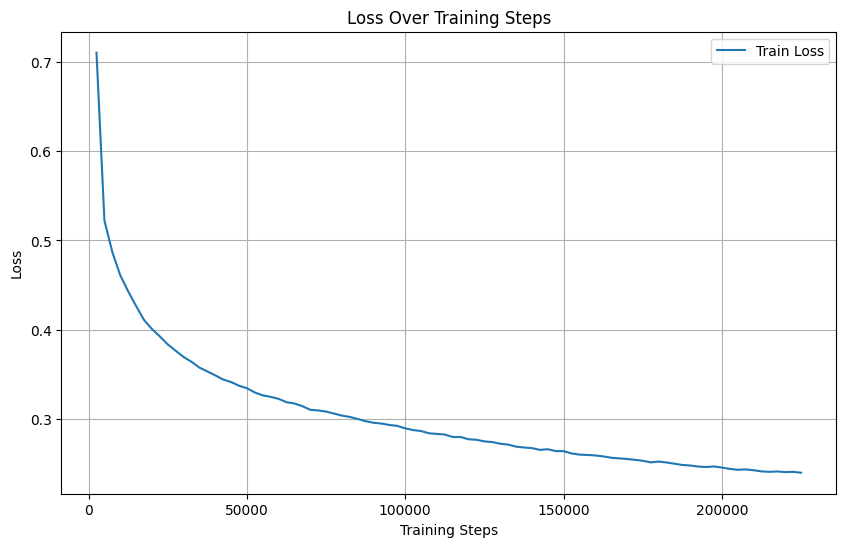

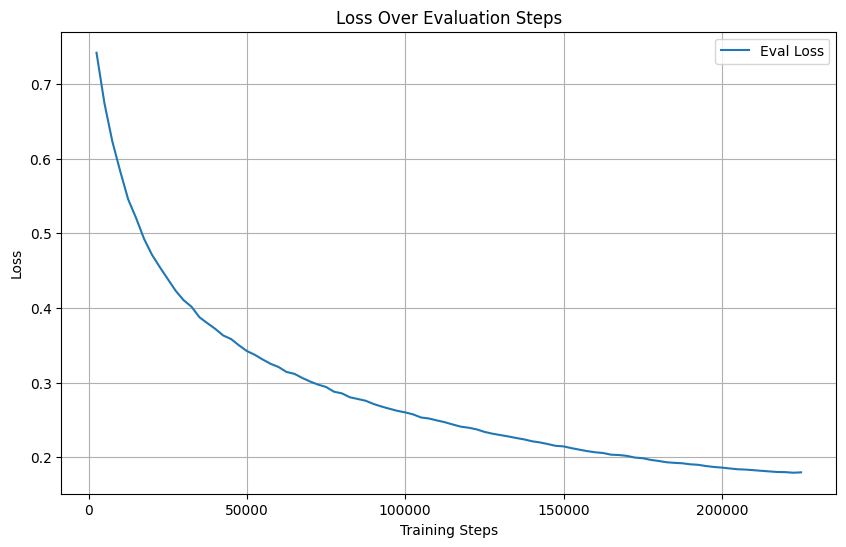

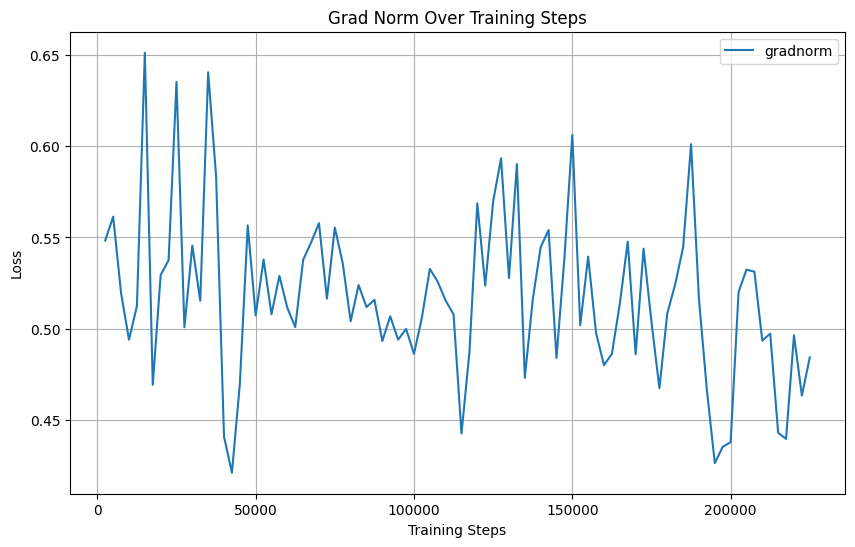

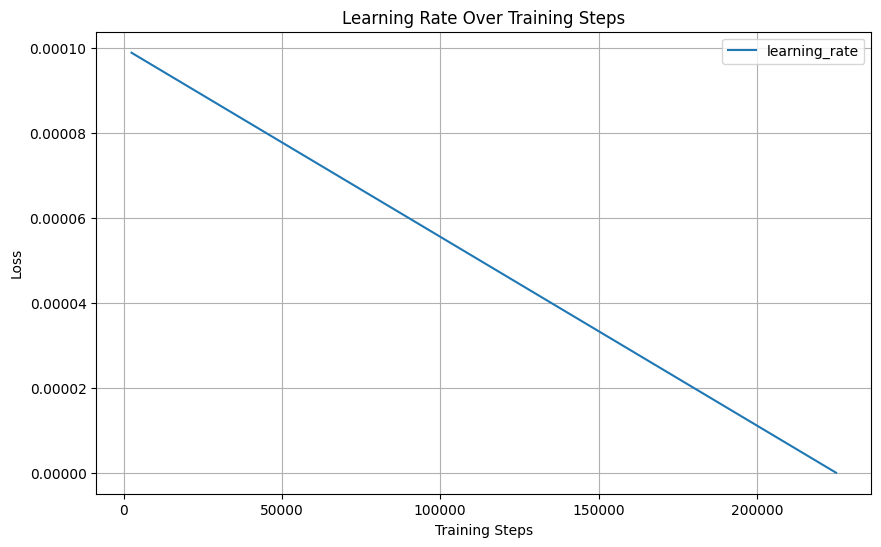

In [71]:
import os
import tensorflow as tf

# Path to the log directory
log_dir = 'D:/Thesis/script_large_logs'

# Initialize lists to hold step numbers and loss values
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []
grad_norm = []
learning_rate = []
runtime = []
# Iterate over the event files in the log directory
for file_name in os.listdir(log_dir):
    file_path = os.path.join(log_dir, file_name)
    
    # Check if the file is an event file
    if file_name.startswith("events.out.tfevents"):
        # Iterate over the events in the file
        for event in tf.compat.v1.train.summary_iterator(file_path):
            runtime.append(event.wall_time)
            for value in event.summary.value:
                # print(value.tag.lower())
                if value.tag.lower() == "train/loss":
                    train_steps.append(event.step)
                    train_losses.append(value.simple_value)
                elif value.tag.lower() == "eval/loss":
                    eval_steps.append(event.step)
                    eval_losses.append(value.simple_value)
                if value.tag.lower() == "train/grad_norm":
                    grad_norm.append(value.simple_value)
                if value.tag.lower() == "train/learning_rate":
                    learning_rate.append(value.simple_value)
runtime = runtime[-1] - runtime[0]
hours = int(runtime// 3600)
remaining_seconds = runtime % 3600
minutes = int(remaining_seconds // 60)
seconds = remaining_seconds % 60
print(f"Training took {hours} hours, {minutes} minutes, and {seconds:.2f} seconds.")

# Optionally, you can plot the loss over steps
if len(train_losses) > 0:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_losses, label="Train Loss",linestyle = '-')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

if len(eval_losses) > 0:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(eval_steps, eval_losses, label="Eval Loss",linestyle = '-')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Over Evaluation Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

if len(grad_norm) > 0:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, grad_norm, label="gradnorm",linestyle = '-')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Grad Norm Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

if len(learning_rate) > 0:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, learning_rate, label="learning_rate",linestyle = '-')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Learning Rate Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

In [66]:
runtime

[1.6649259990720184e+18]

# Dataset setup

In [64]:
MIN_RESIDUES_BEFORE_CDR1 = 20
MIN_RESIDUES_AFTER_CDR3 = 10
CDR1_RANGE = (5, 12)
CDR2_RANGE = (1, 10)
CDR3_RANGE = (5, 38)
def verify_sequence_criteria(row):
    fwr1_length = len(row['fwr1'])
    cdr1_length = len(row['cdr1'])
    fwr2_length = len(row['fwr2'])
    cdr2_length = len(row['cdr2'])
    fwr3_length = len(row['fwr3'])
    cdr3_length = len(row['cdr3'])
    fwr4_length = len(row['fwr4'])

    # Check lengths before CDR1 and after CDR3
    if fwr1_length < MIN_RESIDUES_BEFORE_CDR1 or fwr4_length < MIN_RESIDUES_AFTER_CDR3:
        return False

    # Check CDR lengths
    if not (CDR1_RANGE[0] <= cdr1_length <= CDR1_RANGE[1]):
        return False
    if not (CDR2_RANGE[0] <= cdr2_length <= CDR2_RANGE[1]):
        return False
    if not (CDR3_RANGE[0] <= cdr3_length <= CDR3_RANGE[1]):
        return False

    return True
    


df = pd.DataFrame()
df["v_call"] = df_1600["v_call"]
df["fwr1"] =df_1600["fwr1_aa"]
df["cdr1"] =df_1600["cdr1_aa"]
df["fwr2"] =df_1600["fwr2_aa"]
df["cdr2"] =df_1600["cdr2_aa"]
df["fwr3"] =df_1600["fwr3_aa"]
df["cdr3"] =df_1600["cdr3_aa"]
df["fwr4"] =df_1600["fwr4_aa"]
df["sequence"] = df["fwr1"] + df["cdr1"] + df["fwr2"] + df["cdr2"] + df["fwr3"] + df["cdr3"] + df["fwr4"]
float_indices = df[df["sequence"].apply(lambda x: isinstance(x, float))].index
df.drop(float_indices,inplace=True)
df.reset_index(drop=True,inplace=True)
df['meets_criteria'] = df.apply(verify_sequence_criteria, axis=1)
print(df['meets_criteria'].value_counts())
df = df[df['meets_criteria']].copy()
print(df['meets_criteria'].value_counts())
df.reset_index(drop=True,inplace=True)
df

meets_criteria
True     1550920
False     106437
Name: count, dtype: int64
meets_criteria
True    1550920
Name: count, dtype: int64


,v_call,fwr1,cdr1,fwr2,cdr2,fwr3,cdr3,fwr4,sequence,meets_criteria
0,IGHV1S45*01,EQLEESGGGLVKPEGSLTLTCKAS,GVSLNDKDV,MCWVRQAPGKGLEWIAC,INIVTGKS,VYASWAKGRFTMSRTSSTTVTLRMTSLTAADRATYFC,ARDLVGVIGWNFYL,WGPGTLVTVS,EQLEESGGGLVKPEGSLTLTCKASGVSLNDKDVMCWVRQAPGKGLE...,True
1,IGHV1S45*01,QEQLVESGGGLVKPEGSLKLSCTAS,GFSFSNKAV,MCWVRQAPGKGLEWIAC,INAVTGKA,VYASWAKGRFTFSKTSSTTVTLQVTSLTAADTATYFC,ARDLTGVIGWNFGW,WGPGTLVTVS,QEQLVESGGGLVKPEGSLKLSCTASGFSFSNKAVMCWVRQAPGKGL...,True
2,IGHV1S45*01,EQLEESGGGLVKPEGSLTLTCKAS,GVSLNDKDV,MCWVRQAPGKGLEWIAC,INIVTGKS,VYASWAKGRFIMSRTSSTTVTLQMTSLTAADTATYFC,ARDLVAVIGWNFNL,WGPGTLVTVS,EQLEESGGGLVKPEGSLTLTCKASGVSLNDKDVMCWVRQAPGKGLE...,True
3,IGHV1S47*01,QEQLKEAGGGLVQPGGSLTLSCKAS,GFDFSAYG,VSWVRQAPGKGLEWIGY,IEPIFGNT,YYANWVNGRFTISSHNAQNTLYLQLSSLTAADTATYFC,VRDQAGDADYGPYYLNL,WGPGTLVTVS,QEQLKEAGGGLVQPGGSLTLSCKASGFDFSAYGVSWVRQAPGKGLE...,True
4,IGHV1S45*01,QEQLVESGGDLVKPGASLTLTCTAS,GFSFSSSDY,MCWARQAPGKGLEWIAC,IAGSSSGFT,YSATWAKGRFTCSKTSSTTVTLQMTSLTVADTATYFC,ARDTGSSFSSYGMDL,WGPGTLVTVS,QEQLVESGGDLVKPGASLTLTCTASGFSFSSSDYMCWARQAPGKGL...,True
...,...,...,...,...,...,...,...,...,...,...
1550915,IGHV1S45*01,QEQLVESGGGLVKPEGSLKLSCTAS,GFSFSNKAV,MCWVRQAPGKGLEWIAC,INAVTGKA,VYANWAKGRFAFSKTSSTTVTLQMTSLTAADTATYFC,ARDLAGVIGWNFGW,WGQGTLVTVS,QEQLVESGGGLVKPEGSLKLSCTASGFSFSNKAVMCWVRQAPGKGL...,True
1550916,IGHV1S45*01,QEQLVESGGGLVKPEGSLKLSCTGS,GFSFSNKAV,MCWVRQAPGKGLEWIAC,INTITGKT,VYATWAKGRFTISKPSSTTVTLQMTSLTAADTATYFC,ARNSGNISPWFAL,WGQGTLVTVS,QEQLVESGGGLVKPEGSLKLSCTGSGFSFSNKAVMCWVRQAPGKGL...,True
1550917,IGHV1S45*01,QEQLVESGGGLVQPEGSLTLTCKAS,GIDFSSYYY,MCWVRQAPGKGLEWIGC,IYTGNSIT,YYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFC,ARGSSGGYLYAFKL,WGPGTLVTVS,QEQLVESGGGLVQPEGSLTLTCKASGIDFSSYYYMCWVRQAPGKGL...,True
1550918,IGHV1S45*01,QEQLVESGGGLVQPEGSLALTCKAS,GFDFSSNA,MCWVRQAPGKGLECIAC,IYGGSGGSP,WSASWAKGRFTISKTSSTTVTLQVTSLTAADTATYFC,ARDTSSSFSSYGMDL,WGPGTLVTVS,QEQLVESGGGLVQPEGSLALTCKASGFDFSSNAMCWVRQAPGKGLE...,True


In [42]:

train_len =int(df["sequence"].count()*0.8)
eval_len = int(df["sequence"].count()*0.9)
# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(df[["sequence"]][:train_len])
eval_dataset = Dataset.from_pandas(df[["sequence"]][train_len:eval_len])
test_dataset = Dataset.from_pandas(df[["sequence"]][eval_len:df["sequence"].count()])
dataset_dict = DatasetDict({
    "train": train_dataset,
    "eval": eval_dataset,
    "test": test_dataset
})
# Tokenize the SEQUENCE_INPUT
def tokenize_function(examples):
    return tokenizer(
        examples["sequence"],
        padding="max_length",
        truncation=True,
        max_length=150,
        return_special_tokens_mask=True,
    )

# Tokenize the datasets
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True, remove_columns=["sequence"])

# Display the tokenized dataset
print(tokenized_dataset)



In [3]:
# text_datasets = {
#     "train": ['C:/Users/omala/OneDrive/Bureau/Imperial/Project/code/assets/train_small.txt'],
#     "eval": ['C:/Users/omala/OneDrive/Bureau/Imperial/Project/code/assets/val_small.txt'],
#     "test": ['C:/Users/omala/OneDrive/Bureau/Imperial/Project/code/assets/test_small.txt']
# }
# dataset = load_dataset("text", data_files=text_datasets)
# tokenized_dataset = dataset.map(
#     lambda z: tokenizer(
#         z["text"],
#         padding="max_length",
#         truncation=True,
#         max_length=150,
#         return_special_tokens_mask=True,
#     ),
#     batched=True,
#     num_proc=1,
#     remove_columns=["text"],
# )



# Embeddings of tokens by average

In [33]:
embeddings = []
f_embeddings = []
test_subset = tokenized_dataset["test"]["input_ids"][-1000:]
tensor_test_subset = torch.tensor(test_subset)
for i in range(0, 1000, 8):  # Batch size of 8
        batch = tensor_test_subset[i:i+8]
        # Convert to dictionary of tensors and move to device
        
        outputs = model["large"](batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1].detach().numpy())
        f_embeddings.append(hidden_states[0].detach().numpy())

embeddings = np.concatenate(embeddings, axis=0)
f_embeddings = np.concatenate(f_embeddings, axis=0)
print(embeddings.shape,f_embeddings.shape)

(1000, 150, 768) (1000, 150, 768)


In [34]:
 # Replace with actual sequences

# Flatten the embeddings and associate each position with its corresponding amino acid
amino_acid_to_embeddings = {}
f_amino_acid_to_embeddings = {}
for seq_index, seq in enumerate(test_subset):
    for pos_index, amino_acid in enumerate(seq):
        if amino_acid not in amino_acid_to_embeddings:
            amino_acid_to_embeddings[amino_acid] = []
            f_amino_acid_to_embeddings[amino_acid] = []
        amino_acid_to_embeddings[amino_acid].append(embeddings[seq_index, pos_index])
        f_amino_acid_to_embeddings[amino_acid].append(f_embeddings[seq_index, pos_index])
print(amino_acid_to_embeddings.keys(),
f_amino_acid_to_embeddings.keys())

dict_keys([0, 18, 22, 14, 8, 20, 10, 17, 19, 6, 5, 9, 24, 15, 11, 23, 13, 12, 7, 21, 16, 2, 1, 3]) dict_keys([0, 18, 22, 14, 8, 20, 10, 17, 19, 6, 5, 9, 24, 15, 11, 23, 13, 12, 7, 21, 16, 2, 1, 3])


In [35]:
averaged_dic_embeddings = {aa: np.mean(np.array(embeds), axis=0) for aa, embeds in amino_acid_to_embeddings.items()}
f_averaged_dic_embeddings = {aa: np.mean(np.array(embeds), axis=0) for aa, embeds in f_amino_acid_to_embeddings.items()}
print(averaged_dic_embeddings.keys())
vocab = {
  "<s>": 0,
  "<pad>": 1,
  "</s>": 2,
  "<unk>": 3,
  "<mask>": 4,
  "A": 5,
  "C": 6,
  "D": 7,
  "E": 8,
  "F": 9,
  "G": 10,
  "H": 11,
  "I": 12,
  "K": 13,
  "L": 14,
  "M": 15,
  "N": 16,
  "P": 17,
  "Q": 18,
  "R": 19,
  "S": 20,
  "T": 21,
  "V": 22,
  "W": 23,
  "Y": 24
}
# Create a new dictionary to hold the updated mappings
new_averaged_dic_embeddings = {}
f_new_averaged_dic_embeddings = {}
# Iterate over a copy of the original dictionary's keys
for key in list(averaged_dic_embeddings.keys()):
    for char, index in vocab.items():
        if key == index :
            new_averaged_dic_embeddings[char] = averaged_dic_embeddings.pop(key)
            f_new_averaged_dic_embeddings[char] = f_averaged_dic_embeddings.pop(key)
new_averaged_dic_embeddings.keys()




dict_keys([0, 18, 22, 14, 8, 20, 10, 17, 19, 6, 5, 9, 24, 15, 11, 23, 13, 12, 7, 21, 16, 2, 1, 3])


dict_keys(['<s>', 'Q', 'V', 'L', 'E', 'S', 'G', 'P', 'R', 'C', 'A', 'F', 'Y', 'M', 'H', 'W', 'K', 'I', 'D', 'T', 'N', '</s>', '<pad>', '<unk>'])

In [36]:
amino_acids = list(new_averaged_dic_embeddings.keys())
embeddings_avg = np.array(list(new_averaged_dic_embeddings.values()))
f_embeddings_avg = np.array(list(f_new_averaged_dic_embeddings.values()))
f_embeddings_avg.shape

(24, 768)

c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


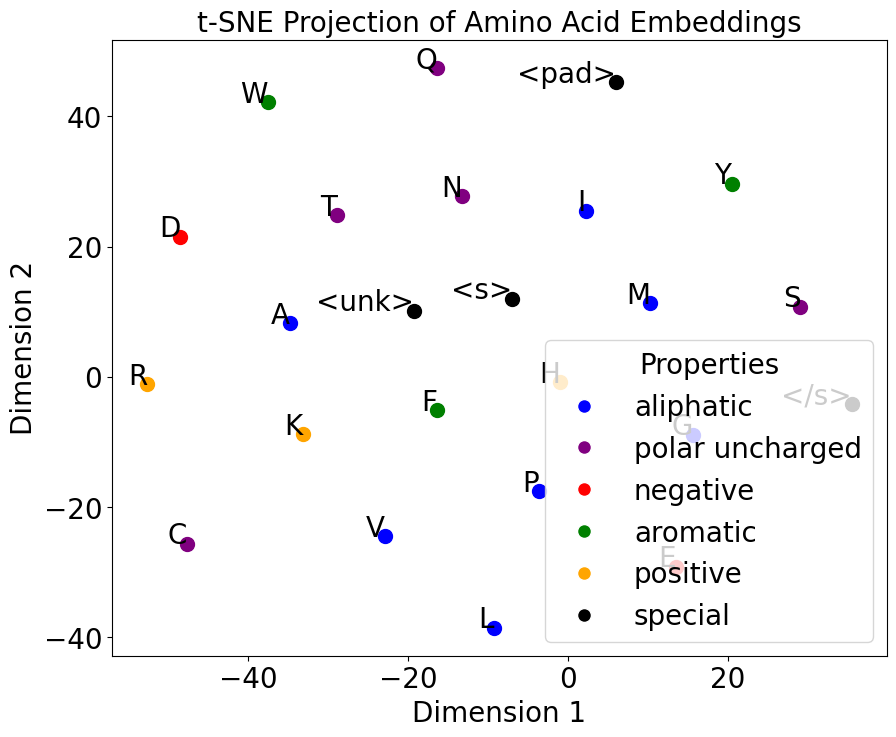

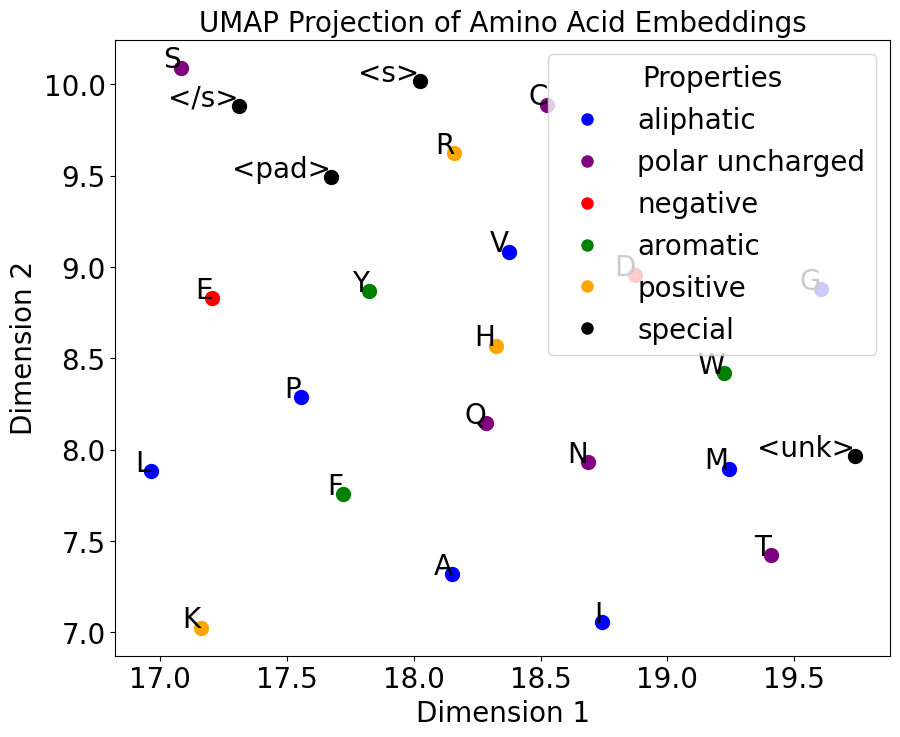

In [39]:
tsne = TSNE(n_components=2, perplexity=20, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001, random_state=42)
umap_results = umap_reducer.fit_transform(embeddings_avg)

amino_acid_properties = {
    "<s>": "special",
    "<pad>": "special",
    "</s>": "special",
    "<unk>": "special",
    "<mask>": "special",
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange','special':'black'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# Visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = tsne_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.title("t-SNE Projection of Amino Acid Embeddings", fontsize=20)
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.title("UMAP Projection of Amino Acid Embeddings", fontsize=20)
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
plt.show()


c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


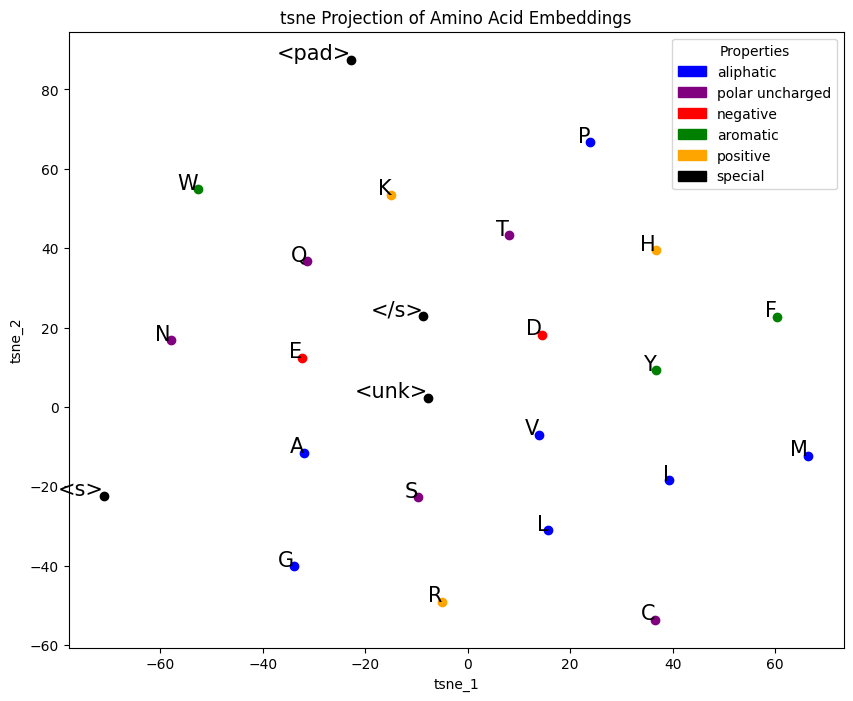

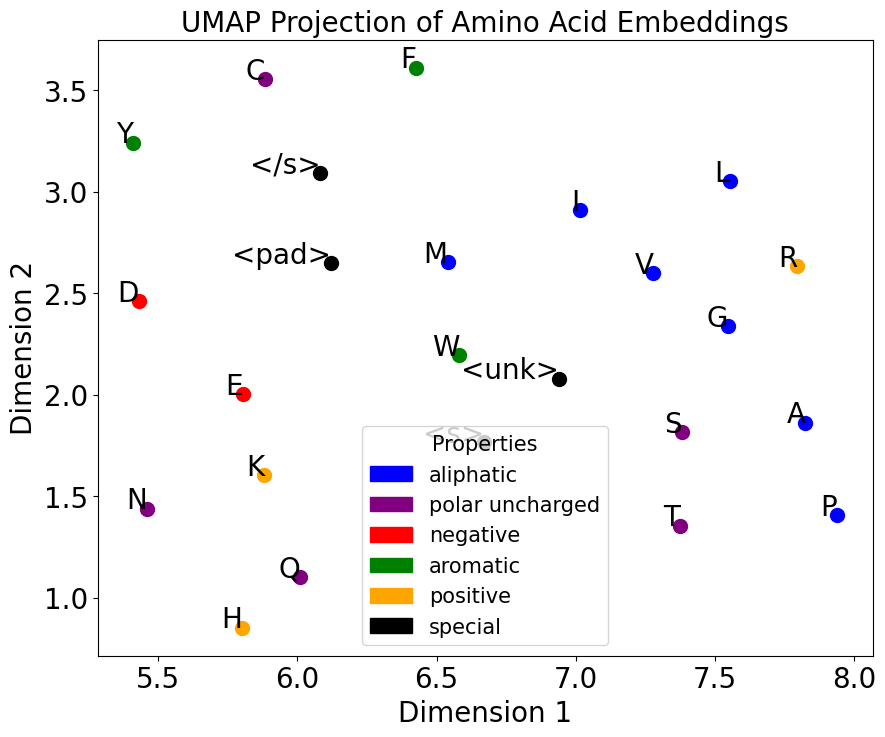

In [41]:
tsne = TSNE(n_components=2, perplexity=20, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(f_embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001, random_state=42)
umap_results = umap_reducer.fit_transform(f_embeddings_avg)

amino_acid_properties = {
    "<s>": "special",
    "<pad>": "special",
    "</s>": "special",
    "<unk>": "special",
    "<mask>": "special",
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange','special':'black'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# Visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = tsne_results[i, :]
    plt.scatter(x, y,color = property_colors[amino_acid_properties[label]])
    plt.text(x, y, label, fontsize=15, ha='right')

plt.title('tsne Projection of Amino Acid Embeddings')
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')

plt.legend(handles=legend_elements, title='Properties')
plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.title("UMAP Projection of Amino Acid Embeddings", fontsize=20)
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=legend_elements, title="Properties",fontsize = 15, title_fontsize = 15)    
plt.show()


c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


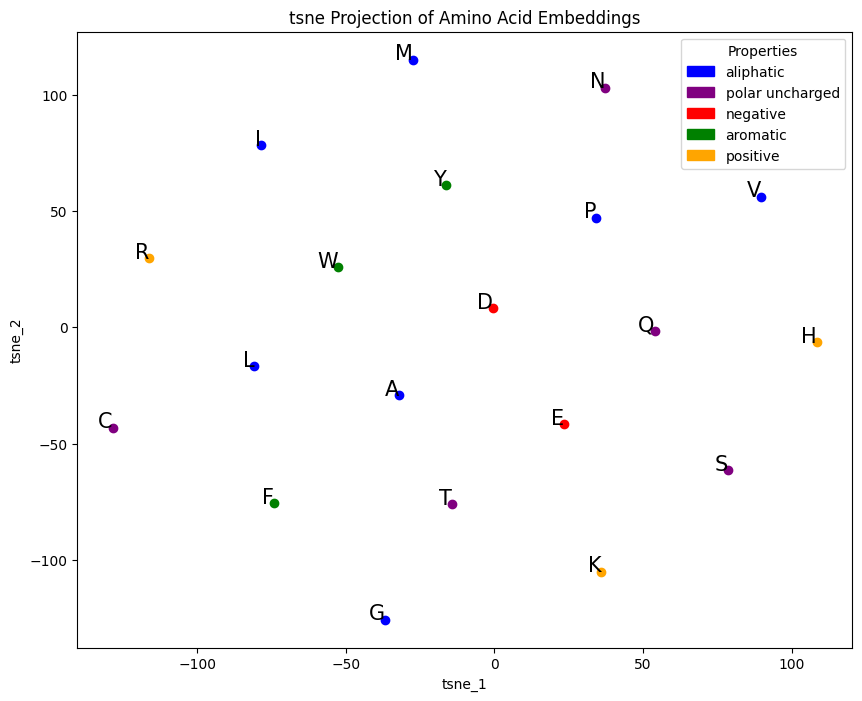

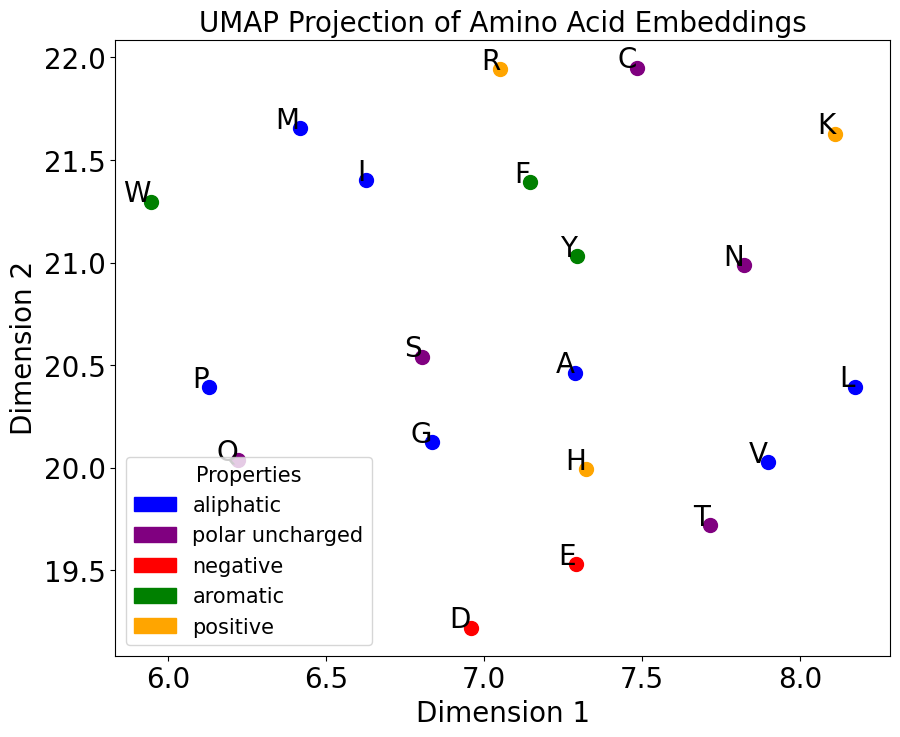

In [43]:
no_special = {k: v for k, v in new_averaged_dic_embeddings.items() if k not in ['<s>', '<pad>', '</s>', '<unk>', '<mask>']}
no_special_amino_acids = list(no_special.keys())
no_special_embeddings_avg = np.array(list(no_special.values()))

tsne = TSNE(n_components=2, perplexity=19, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(no_special_embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.001, random_state=42)
umap_results = umap_reducer.fit_transform(no_special_embeddings_avg)

no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# Visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(no_special_amino_acids):
    x, y = tsne_results[i, :]
    plt.scatter(x, y,color = property_colors[no_special_amino_acid_properties[label]])
    plt.text(x, y, label, fontsize=15, ha='right')

plt.title('tsne Projection of Amino Acid Embeddings')
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')

plt.legend(handles=legend_elements, title='Properties')
plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(no_special_amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.title("UMAP Projection of Amino Acid Embeddings", fontsize=20)
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=legend_elements, title="Properties",fontsize = 15, title_fontsize = 15)    
plt.show()


c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


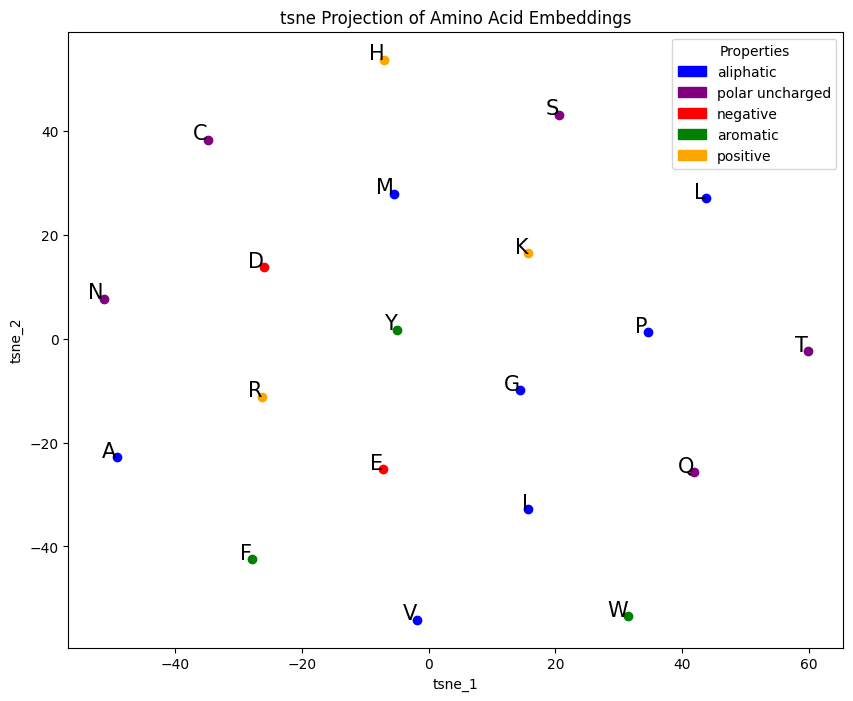

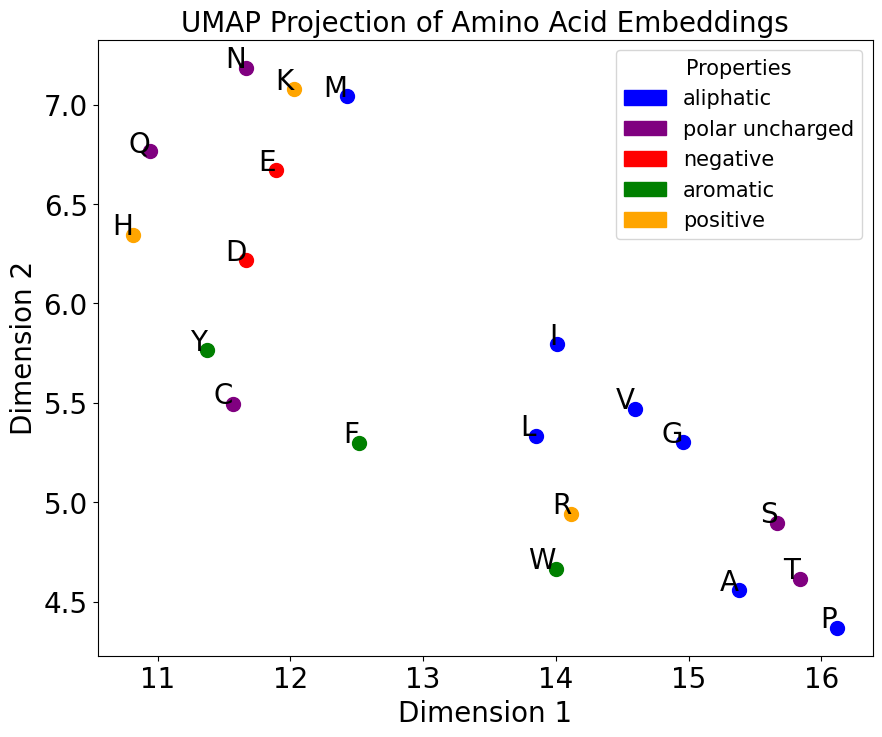

In [46]:
f_no_special = {k: v for k, v in f_new_averaged_dic_embeddings.items() if k not in ['<s>', '<pad>', '</s>', '<unk>', '<mask>']}
f_no_special_amino_acids = list(f_no_special.keys())
f_no_special_embeddings_avg = np.array(list(f_no_special.values()))

tsne = TSNE(n_components=2, perplexity=19, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(f_no_special_embeddings_avg)

umap_reducer = umap.UMAP(n_components=2, n_neighbors=3, min_dist=0.001, random_state=42)
umap_results = umap_reducer.fit_transform(f_no_special_embeddings_avg)

no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
legend_elements = [mpatches.Patch(color=color, label=key) for key, color in property_colors.items()]

# Visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(no_special_amino_acids):
    x, y = tsne_results[i, :]
    plt.scatter(x, y,color = property_colors[no_special_amino_acid_properties[label]])
    plt.text(x, y, label, fontsize=15, ha='right')

plt.title('tsne Projection of Amino Acid Embeddings')
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')

plt.legend(handles=legend_elements, title='Properties')
plt.show()
plt.figure(figsize=(10, 8))
for i, label in enumerate(no_special_amino_acids):
    x, y = umap_results[i, :]
    plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=100)
    plt.text(x, y, label, fontsize=20, ha='right')
plt.title("UMAP Projection of Amino Acid Embeddings", fontsize=20)
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(handles=legend_elements, title="Properties",fontsize = 15, title_fontsize = 15)    
plt.show()


# Token embeddings from model

In [32]:

model["large"].eval()
word_token_embeddings_large = model["large"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()
model["medium"].eval()
word_token_embeddings_medium = model["medium"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()
model["small"].eval()
word_token_embeddings_small = model["small"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()
word_token_embeddings = {"large":token_embeddings_large, "medium":token_embeddings_medium, "small":token_embeddings_small}
# token_embeddings = token_embeddings / np.linalg.norm(token_embeddings, axis=1)[:, None]
word_token_embeddings["large"].shape

(25, 768)

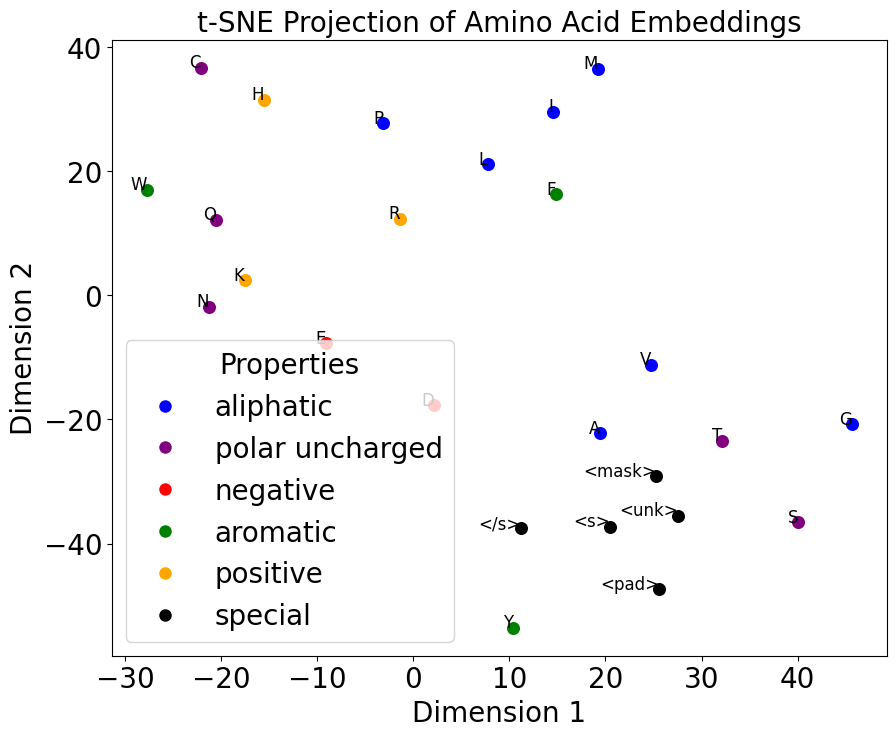

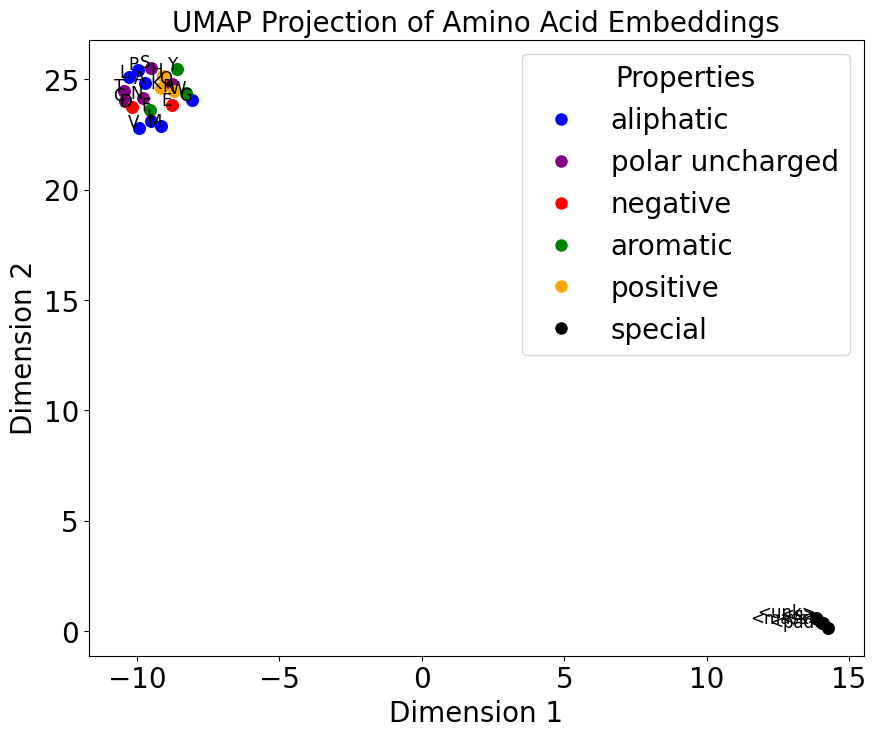

In [22]:
amino_acid_properties = {
    "<s>": "special",
    "<pad>": "special",
    "</s>": "special",
    "<unk>": "special",
    "<mask>": "special",
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange', 'special': 'black'}
tsne = TSNE(n_components=2,n_iter=3000, random_state=42, perplexity=2)
tsne_results = tsne.fit_transform(word_token_embeddings["large"])

# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_results = umap_reducer.fit_transform(word_token_embeddings["large"])
amino_acids = list(amino_acid_properties.keys())
# Function to plot embeddings
def plot_embeddings(results, title):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[amino_acid_properties[label]],s=70)
        plt.text(x, y, label, fontsize=12, ha='right')
    plt.xlabel('Dimension 1', fontsize=20)
    plt.ylabel('Dimension 2', fontsize=20)
    plt.title(title, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)
    plt.show()

# Plot t-SNE results
plot_embeddings(tsne_results, 't-SNE Projection of Amino Acid Embeddings')

# Plot UMAP results
plot_embeddings(umap_results, 'UMAP Projection of Amino Acid Embeddings')

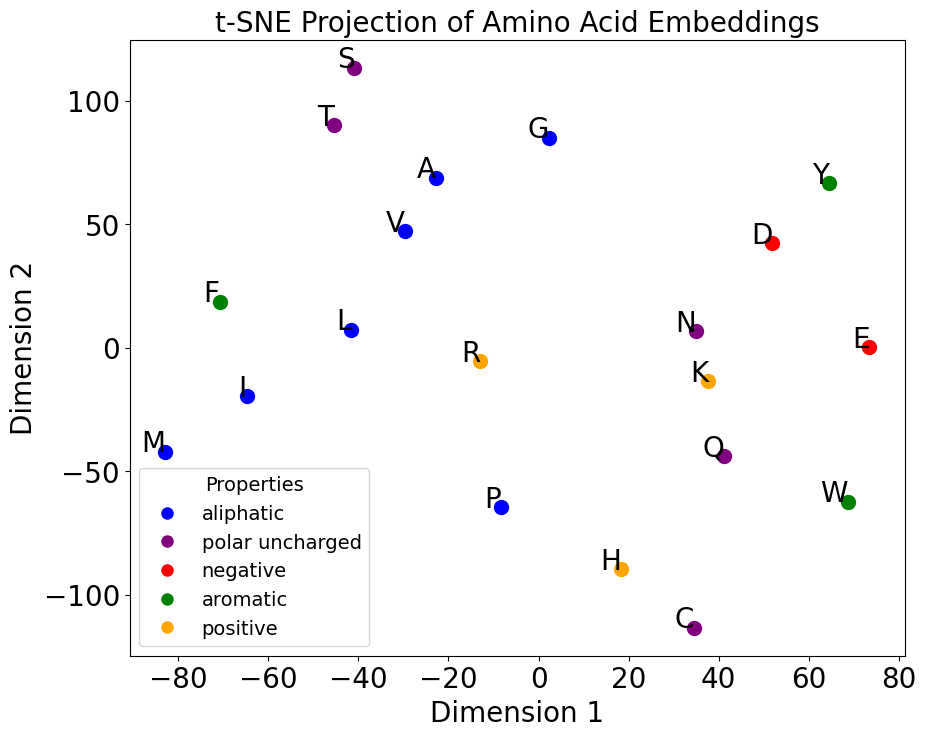

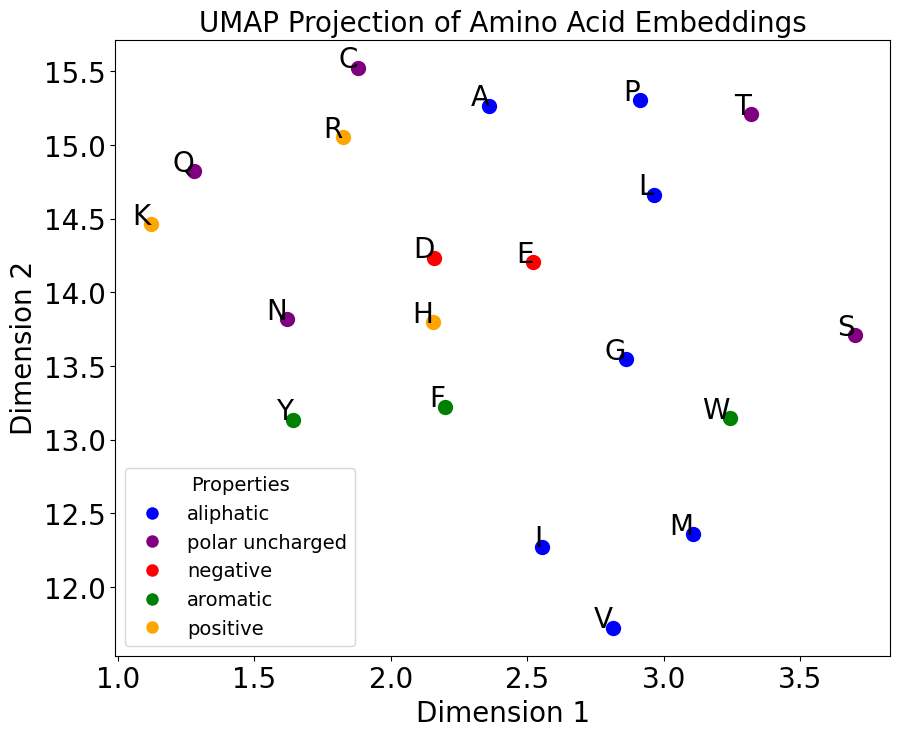

In [30]:
no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
no_special_amino_acids = list(no_special_amino_acid_properties.keys())
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
tsne = TSNE(n_components=2, random_state=42, perplexity=3,n_iter=30000)
tsne_results = tsne.fit_transform(word_token_embeddings["large"][5:])
# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_results = umap_reducer.fit_transform(word_token_embeddings["large"][5:])

# Function to plot embeddings
def plot_embeddings(results, title):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(no_special_amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[no_special_amino_acid_properties[label]], s=100)
        plt.text(x, y, label, fontsize=20, ha='right')
    plt.xlabel('Dimension 1', fontsize=20)
    plt.ylabel('Dimension 2', fontsize=20)
    plt.title(title, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 14, title_fontsize = 14)
    plt.show()

# Plot t-SNE results
plot_embeddings(tsne_results, 't-SNE Projection of Amino Acid Embeddings')

# Plot UMAP results
plot_embeddings(umap_results, 'UMAP Projection of Amino Acid Embeddings')

# Token embeddings 1 token sequences


In [6]:
sequences = Dataset.from_dict({"sequence": ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]})
def tokenize_function(examples):
    return tokenizer(
        examples["sequence"],
        padding="max_length",
        truncation=True,
        max_length=150,
        return_special_tokens_mask=True,
    )

dataset_dict = DatasetDict({
    "test": sequences
})
# Tokenize the datasets
one_tokenized_dataset = dataset_dict.map(tokenize_function, batched=True, remove_columns=["sequence"])

# Display the tokenized dataset
print(one_tokenized_dataset)

one_test_subset = one_tokenized_dataset["test"]["input_ids"]
one_test_subset = torch.tensor(one_test_subset)

Map: 100%|██████████| 20/20 [00:00<00:00, 999.04 examples/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask'],
        num_rows: 20
    })
})


In [7]:
one_token_embeddings = {}
one_f_token_embeddings = {}
model_large = model["large"]
model_large.eval()
token_embeddings = []
f_token_embeddings = []
outputs = model_large(one_test_subset)
hidden_states = outputs.hidden_states
token_embeddings.append(hidden_states[-1].detach().numpy())  
f_token_embeddings.append(hidden_states[0].detach().numpy()) 
token_embeddings = np.concatenate(token_embeddings, axis=0)
f_token_embeddings = np.concatenate(f_token_embeddings, axis=0)
token_embeddings = token_embeddings[:,0,:]
f_token_embeddings = f_token_embeddings[:,0,:]
one_token_embeddings["large"] = token_embeddings
one_f_token_embeddings["large"] = f_token_embeddings

model_medium = model["medium"]
model_medium.eval()
token_embeddings = []
f_token_embeddings = []
outputs = model_medium(one_test_subset)
hidden_states = outputs.hidden_states
token_embeddings.append(hidden_states[-1].detach().numpy())  
f_token_embeddings.append(hidden_states[0].detach().numpy()) 
token_embeddings = np.concatenate(token_embeddings, axis=0)
f_token_embeddings = np.concatenate(f_token_embeddings, axis=0)
token_embeddings = token_embeddings[:,0,:]
f_token_embeddings = f_token_embeddings[:,0,:]
one_token_embeddings["medium"] = token_embeddings
one_f_token_embeddings["medium"] = f_token_embeddings

model_small = model["small"]
model_small.eval()
token_embeddings = []
f_token_embeddings = []
outputs = model_small(one_test_subset)
hidden_states = outputs.hidden_states
token_embeddings.append(hidden_states[-1].detach().numpy())  
f_token_embeddings.append(hidden_states[0].detach().numpy()) 
token_embeddings = np.concatenate(token_embeddings, axis=0)
f_token_embeddings = np.concatenate(f_token_embeddings, axis=0)
token_embeddings = token_embeddings[:,0,:]
f_token_embeddings = f_token_embeddings[:,0,:]
one_token_embeddings["small"] = token_embeddings
one_f_token_embeddings["small"] = f_token_embeddings

print(one_token_embeddings["large"].shape,one_f_token_embeddings["large"].shape)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


(20, 768) (20, 768)


c:\Users\omala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


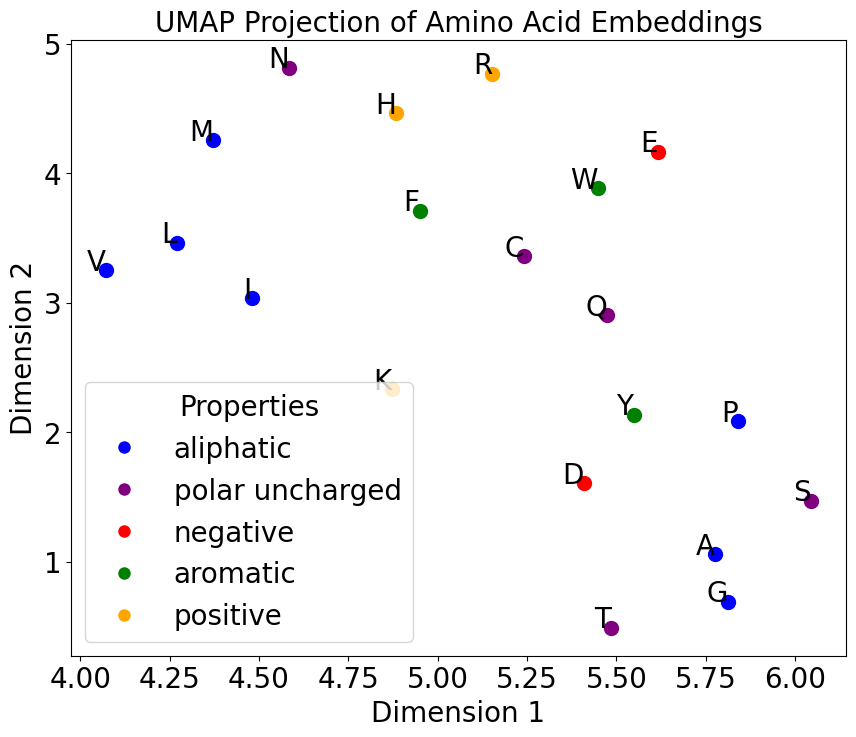

In [16]:
no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
no_special_amino_acids = list(no_special_amino_acid_properties.keys())
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
tsne = TSNE(n_components=2, random_state=42, perplexity=3,n_iter=3000)
tsne_results = tsne.fit_transform(one_token_embeddings["large"])

# UMAP
seed=40
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine',random_state=seed)
umap_results = umap_reducer.fit_transform(one_token_embeddings["large"])

# Function to plot embeddings
def plot_embeddings(results, title):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(no_special_amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[no_special_amino_acid_properties[label]],s=100)
        plt.text(x, y, label, fontsize=20, ha='right')
    plt.title(title, fontsize=20)
    plt.xlabel('Dimension 1', fontsize=20)
    plt.ylabel('Dimension 2', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
    plt.show()
    

# Plot t-SNE results
# plot_embeddings(tsne_results, 't-SNE Projection of Amino Acid Embeddings')

# Plot UMAP results
plot_embeddings(umap_results, 'UMAP Projection of Amino Acid Embeddings')

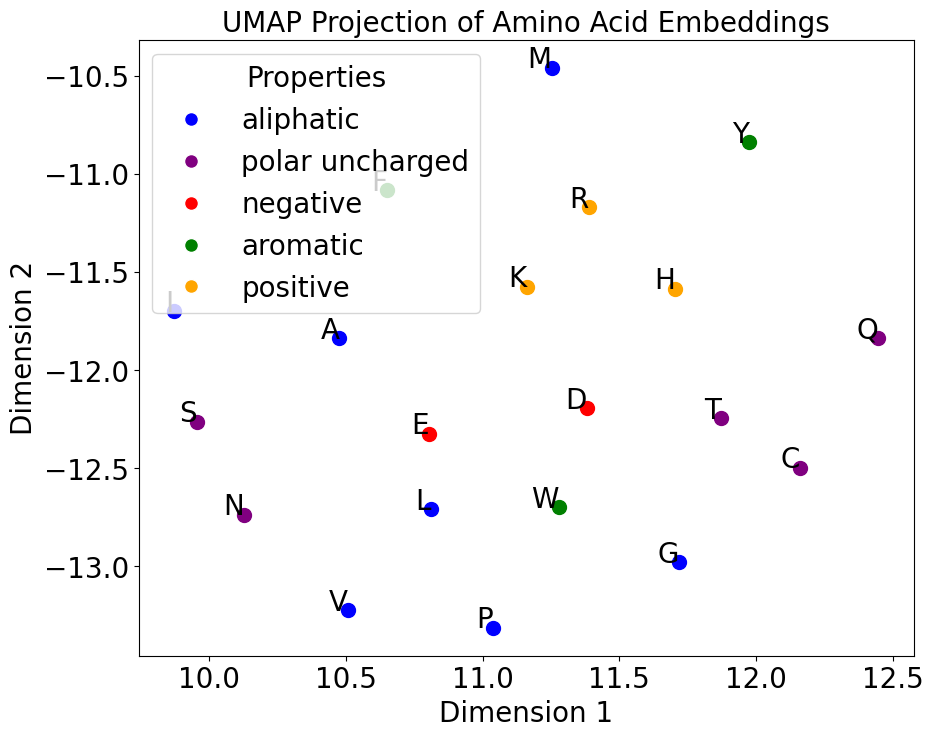

In [30]:
no_special_amino_acid_properties = {
    "A": "aliphatic",      # Alanine
    "C": "polar uncharged",# Cysteine
    "D": "negative",       # Aspartic acid
    "E": "negative",       # Glutamic acid
    "F": "aromatic",       # Phenylalanine
    "G": "aliphatic",      # Glycine
    "H": "positive",       # Histidine
    "I": "aliphatic",      # Isoleucine
    "K": "positive",       # Lysine
    "L": "aliphatic",      # Leucine
    "M": "aliphatic",      # Methionine
    "N": "polar uncharged",# Asparagine
    "P": "aliphatic",      # Proline
    "Q": "polar uncharged",# Glutamine
    "R": "positive",       # Arginine
    "S": "polar uncharged",# Serine
    "T": "polar uncharged",# Threonine
    "V": "aliphatic",      # Valine
    "W": "aromatic",       # Tryptophan
    "Y": "aromatic"        # Tyrosine
}
no_special_amino_acids = list(no_special_amino_acid_properties.keys())
property_colors = {'aliphatic': 'blue', 'polar uncharged': 'purple', 'negative': 'red', 'aromatic': 'green', 'positive': 'orange'}
# tsne = TSNE(n_components=2, random_state=42, perplexity=2,n_iter=3000)
# tsne_results = tsne.fit_transform(one_f_token_embeddings["large"])

# UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.001, metric='cosine')
umap_results = umap_reducer.fit_transform(one_f_token_embeddings["large"])

# Function to plot embeddings
def plot_embeddings(results, title):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(no_special_amino_acids):
        x, y = results[i, :]
        plt.scatter(x, y, color=property_colors[no_special_amino_acid_properties[label]],s=100)
        plt.text(x, y, label, fontsize=20, ha='right')
    plt.title(title, fontsize=20)
    plt.xlabel('Dimension 1', fontsize=20)
    plt.ylabel('Dimension 2', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=property_colors[prop], markersize=10, label=prop) for prop in property_colors], title="Properties",fontsize = 20, title_fontsize = 20)    
    plt.show()

# Plot t-SNE results
# plot_embeddings(tsne_results, 't-SNE Projection of Amino Acid Embeddings')

# Plot UMAP results
plot_embeddings(umap_results, 'UMAP Projection of Amino Acid Embeddings')

# Embeddings visualisation of V_FAM

In [6]:
dataset = pd.read_csv("D:/Thesis/dataset_12.csv")

In [65]:
V_FAM = dataset["v_call"][-1000:]
V_FAM = V_FAM.reset_index(drop =True)

def extract_v_gene_type(ighv_string):
    # Use a regular expression to find the V gene type
    match = re.match(r"IGHV(\d+)-", ighv_string)
    if match:
        # Return the V gene type in the format "V<number>"
        return f"V{match.group(1)}"
    else:
        # If the string doesn't match the expected format, return None or an error message
        return None

for i,label in enumerate(V_FAM):
    V_FAM[i] = extract_v_gene_type(label)
V_FAM.value_counts()

v_call
V3    663
V4    163
V1    140
V2     25
V6      6
V5      3
Name: count, dtype: int64

In [66]:
embeddings = []
f_embeddings = []
test_subset = tokenized_dataset["test"]["input_ids"][-1000:]
tensor_test_subset = torch.tensor(test_subset)
print(tensor_test_subset.shape)
for i in range(0, 1000, 8):  # Batch size of 8
        batch = tensor_test_subset[i:i+8]
        # Convert to dictionary of tensors and move to device
        
        outputs = model["medium"](batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1].detach().numpy())
        f_embeddings.append(hidden_states[0].detach().numpy())

embeddings = np.concatenate(embeddings, axis=0)
f_embeddings = np.concatenate(f_embeddings, axis=0)
print(embeddings.shape,f_embeddings.shape)

torch.Size([1000, 150])
(1000, 150, 768) (1000, 150, 768)


In [67]:
# Assuming embeddings is of shape (2516, 150, 256)
import umap
import matplotlib.pyplot as plt
n_samples, seq_length, embedding_dim = embeddings.shape
reshaped_embeddings1 = embeddings.reshape(n_samples * seq_length, embedding_dim)
reshaped_embeddings2 = embeddings.reshape(n_samples, seq_length * embedding_dim)
average_embeddings = np.mean(embeddings, axis=1)
f_average_embeddings = np.mean(f_embeddings, axis=1)
batch_size = 500  # Adjust batch size based on your memory capacity

# # umap_embeddings = []
# reducer= umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine',)
# umap_embeddings1 = reducer.fit_transform(reshaped_embeddings1)
# reducer= umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
# umap_embeddings2 = reducer.fit_transform(reshaped_embeddings2)

# for i in range(0, n_samples, batch_size):
#     batch_embeddings = embeddings[i:i + batch_size]
#     umap_embeddings.append(reducer.fit_transform(batch_embeddings))

# umap_embeddings = np.concatenate(umap_embeddings, axis=0)



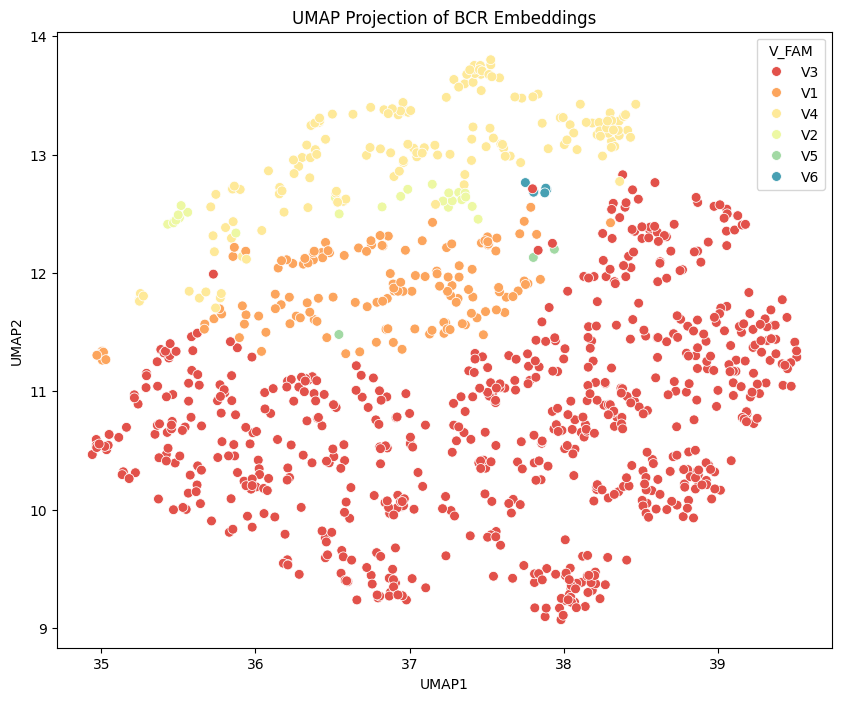

In [96]:
reducer= umap.UMAP(n_neighbors=500, min_dist=0.001, metric='cosine')
umap_embeddings3 = reducer.fit_transform(average_embeddings)
umap_df = pd.DataFrame(umap_embeddings3, columns=['UMAP1', 'UMAP2'])
umap_df["V_FAM"] = V_FAM.values
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=50)
# sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',palette='Spectral', s=50)
plt.title('UMAP Projection of BCR Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


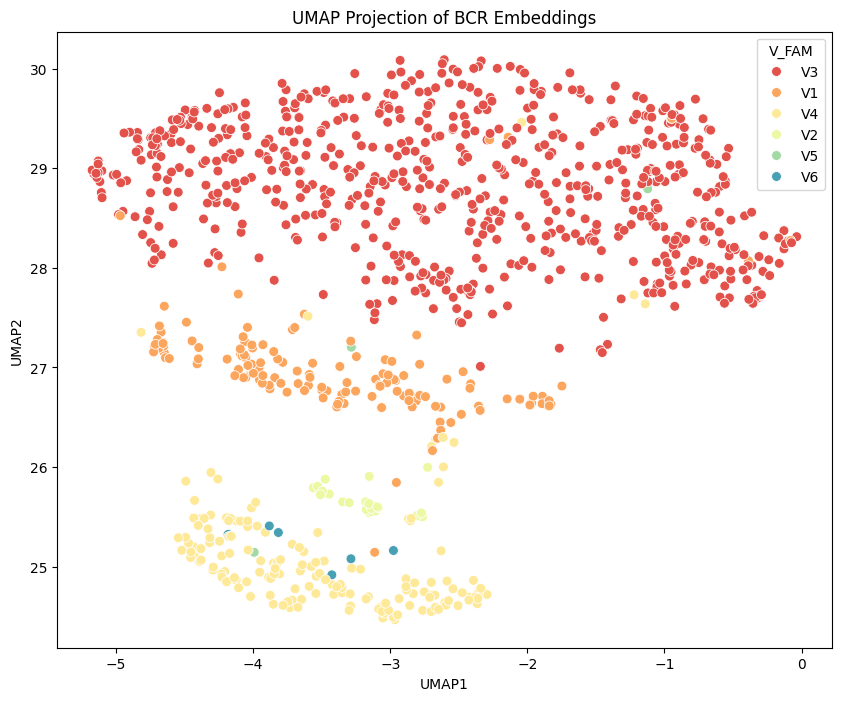

In [91]:
seed=42
f_reducer= umap.UMAP(n_neighbors=2, min_dist=0.0001, metric='cosine',random_state=seed)
f_umap_embeddings3 = reducer.fit_transform(f_average_embeddings)
f_umap_df = pd.DataFrame(f_umap_embeddings3, columns=['UMAP1', 'UMAP2'])
f_umap_df["V_FAM"] = V_FAM.values
plt.figure(figsize=(10, 8))
sns.scatterplot(data=f_umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=50)
# sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',palette='Spectral', s=50)
plt.title('UMAP Projection of BCR Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


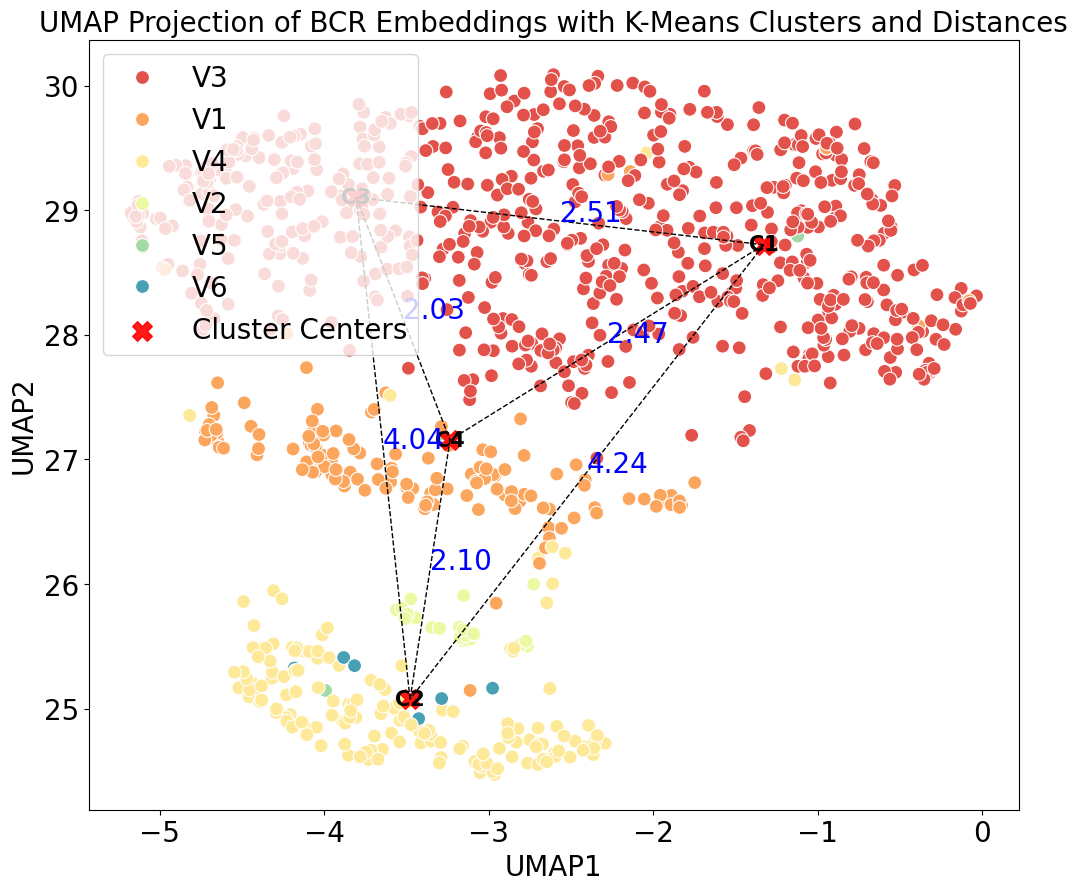

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import umap


# Step 2: Perform K-Means Clustering on the UMAP Embeddings
n_clusters = 4  # Adjust number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(f_umap_df[['UMAP1', 'UMAP2']])

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Get the labels for each data point
labels = kmeans.labels_

# Calculate pairwise distances between cluster centers
cluster_distances = pairwise_distances(cluster_centers, metric='euclidean')

# Step 3: Plot UMAP with K-Means Clusters and Distances
plt.figure(figsize=(12, 10))

# Scatter plot for data points
sns.scatterplot(data=f_umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=100)

# Scatter plot for cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.9, marker='X', label='Cluster Centers')

# Annotate cluster centers with their indices
for i, center in enumerate(cluster_centers):
    plt.text(center[0], center[1], f'C{i+1}', color='black', fontsize=15, ha='center', va='center', weight='bold')

# Plot lines between cluster centers and annotate distances
for i in range(n_clusters):
    for j in range(i + 1, n_clusters):
        center_i = cluster_centers[i]
        center_j = cluster_centers[j]
        distance = cluster_distances[i, j]
        
        # Draw a line between cluster centers
        plt.plot([center_i[0], center_j[0]], [center_i[1], center_j[1]], 'k--', linewidth=1)
        
        # Annotate the line with the distance
        mid_x = (center_i[0] + center_j[0]) / 2
        mid_y = (center_i[1] + center_j[1]) / 2
        plt.text(mid_x, mid_y, f'{distance:.2f}', color='blue', fontsize=20)

# Add title and labels
plt.title('UMAP Projection of BCR Embeddings with K-Means Clusters and Distances',fontsize = 20)
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display legend
plt.legend(loc='upper left', fontsize=20)
plt.show()


In [174]:
df = pd.DataFrame()
df = dataset.copy()

# Assuming df_1600 is your DataFrame

# Step 1: Filter `v_call` types with more than 100 samples
v_call_counts = df["v_call"].value_counts()
v_calls_to_select = v_call_counts[v_call_counts > 50000].index
print(v_calls_to_select)
# Step 2: Select one sequence for each `v_call` type
selected_sequences = []

for v_call in v_calls_to_select:
    sequence = df[df["v_call"] == v_call].iloc[:100] 
    sequence = df[df["v_call"] == v_call].iloc[:100] 
    selected_sequences.append(sequence)

# Step 3: Create a new DataFrame with the selected sequences
selected_df = Dataset.from_pandas(pd.concat(selected_sequences))
# selected_df = Dataset.from_pandas(selected_df)


Index(['IGHV3-23*01', 'IGHV1-18*01', 'IGHV2-5*02', 'IGHV3-30*18',
       'IGHV1-69*12', 'IGHV3-74*01', 'IGHV3-33*01', 'IGHV3-30-3*01',
       'IGHV4-31*03', 'IGHV4-39*01', 'IGHV3-7*05'],
      dtype='object', name='v_call')


In [175]:
def tokenize_function(examples):
    return tokenizer(
        examples["sequence"],
        padding="max_length",
        truncation=True,
        max_length=150,
        return_special_tokens_mask=True,
    )

dataset_dict = DatasetDict({
    "test": selected_df
})
# Tokenize the datasets
test_subset = dataset_dict.map(tokenize_function, batched=True, remove_columns=["sequence"])
test_subset = test_subset["test"]["input_ids"]
test_subset = torch.tensor(test_subset)


Map: 100%|██████████| 1100/1100 [00:00<00:00, 6971.37 examples/s]


In [177]:
embeddings = []
f_embeddings = []
for i in range(0, 8999, 8):  # Batch size of 8
        batch = test_subset[i:i+8]
        # Convert to dictionary of tensors and move to device
        
        outputs = model(batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1].detach().numpy())  # Get the last hidden state
        f_embeddings.append(hidden_states[0].detach().numpy())  # Get the first hidden state
embeddings = np.concatenate(embeddings, axis=0)
f_embeddings = np.concatenate(f_embeddings, axis=0)
embeddings.shape

(1100, 150, 768)

In [178]:
# Assuming embeddings is of shape (2516, 150, 256)
import umap
import matplotlib.pyplot as plt
n_samples, seq_length, embedding_dim = embeddings.shape
# reshaped_embeddings1 = embeddings.reshape(n_samples * seq_length, embedding_dim)
# reshaped_embeddings2 = embeddings.reshape(n_samples, seq_length * embedding_dim)
average_embeddings = np.mean(embeddings, axis=1)
f_average_embeddings = np.mean(f_embeddings, axis=1)
batch_size = 500  # Adjust batch size based on your memory capacity

# # umap_embeddings = []
# reducer= umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine',)
# umap_embeddings1 = reducer.fit_transform(reshaped_embeddings1)
# reducer= umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
# umap_embeddings2 = reducer.fit_transform(reshaped_embeddings2)

# for i in range(0, n_samples, batch_size):
#     batch_embeddings = embeddings[i:i + batch_size]
#     umap_embeddings.append(reducer.fit_transform(batch_embeddings))

# umap_embeddings = np.concatenate(umap_embeddings, axis=0)



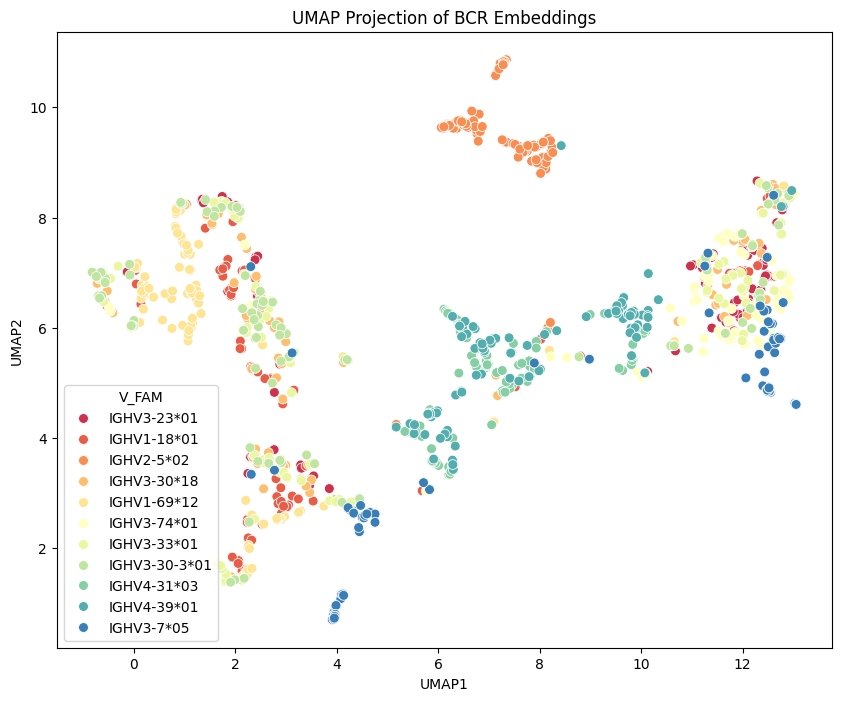

In [184]:
reducer= umap.UMAP(n_neighbors=8, min_dist=0.01, metric='cosine')
umap_embeddings3 = reducer.fit_transform(average_embeddings)
umap_df = pd.DataFrame(umap_embeddings3, columns=['UMAP1', 'UMAP2'])
umap_df["V_FAM"] = selected_df["v_call"]
# umap_df['V_FAM'] = small_df["V_FAM"][2000:2250].values
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=50)
# sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',palette='Spectral', s=50)
plt.title('UMAP Projection of BCR Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


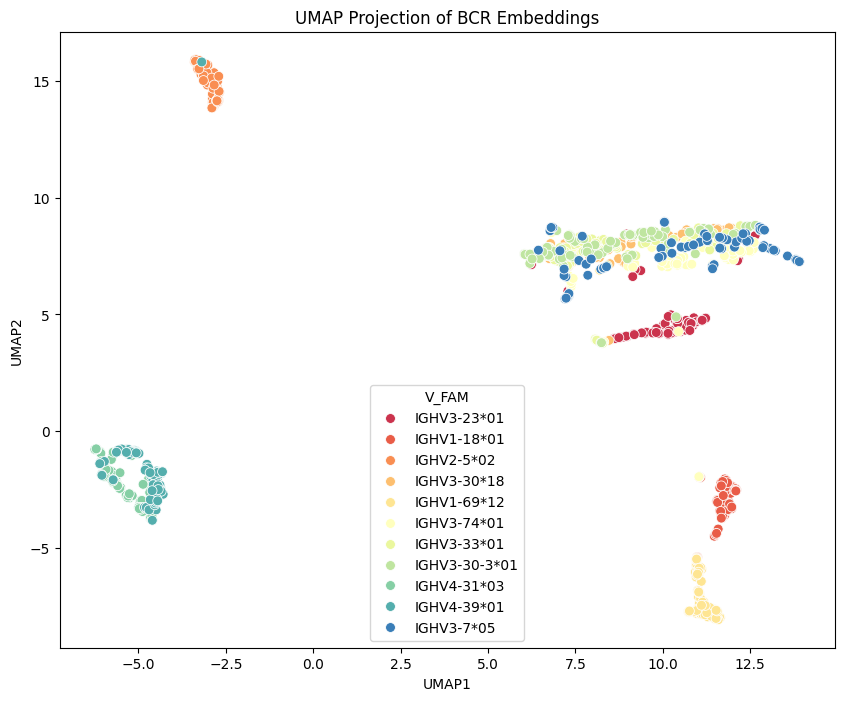

In [189]:
f_reducer= umap.UMAP(n_neighbors=50, min_dist=0.001, metric='cosine')
f_umap_embeddings3 = reducer.fit_transform(f_average_embeddings)
f_umap_df = pd.DataFrame(f_umap_embeddings3, columns=['UMAP1', 'UMAP2'])
f_umap_df["V_FAM"] = selected_df["v_call"]
# umap_df['V_FAM'] = small_df["V_FAM"][2000:2250].values
plt.figure(figsize=(10, 8))
sns.scatterplot(data=f_umap_df, x='UMAP1', y='UMAP2', hue='V_FAM', palette='Spectral', s=50)
# sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2',palette='Spectral', s=50)
plt.title('UMAP Projection of BCR Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


# BLOSUM

## Blosum VS token embedding

In [79]:

model["large"].eval()
token_embeddings = model["large"].roberta.embeddings.word_embeddings.weight.data.cpu().numpy()


# token_embeddings = token_embeddings / np.linalg.norm(token_embeddings, axis=1)[:, None]
token_embeddings.shape

(25, 768)

In [80]:
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

embedding_dict = {aa: token_embeddings[i+5] for i, aa in enumerate(amino_acids)}
embedding_dict.keys()

dict_keys(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

In [81]:
# Compare the embedding similarity with BLOSUM scores
def evaluate_embedding_similarity(embedding_dict, blosum_matrix):
    similarities = []
    for aa1 in embedding_dict:
        for aa2 in embedding_dict:
            if True:
                embedding_similarity = 1 - cosine(embedding_dict[aa1], embedding_dict[aa2])
                blosum_score = blosum_matrix[aa1][aa2]
                similarities.append((embedding_similarity, blosum_score))
    return similarities

# Evaluate
blosum62 = bl.BLOSUM(62)
similarities = evaluate_embedding_similarity(embedding_dict, blosum62)
similarities = np.array(similarities)
similarities.shape

(400, 2)

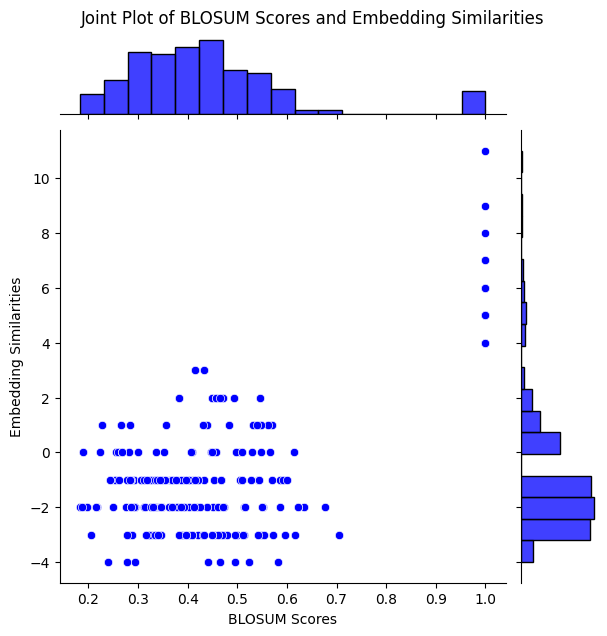

In [82]:
import seaborn as sns
blosum_scores = similarities[:, 0]
embedding_similarities = similarities[:, 1]
# Joint distribution plot
sns.jointplot(x=blosum_scores, y=embedding_similarities, kind='scatter', color='blue')
plt.xlabel('BLOSUM Scores')
plt.ylabel('Embedding Similarities')
plt.suptitle('Joint Plot of BLOSUM Scores and Embedding Similarities', y=1.02)
plt.show()


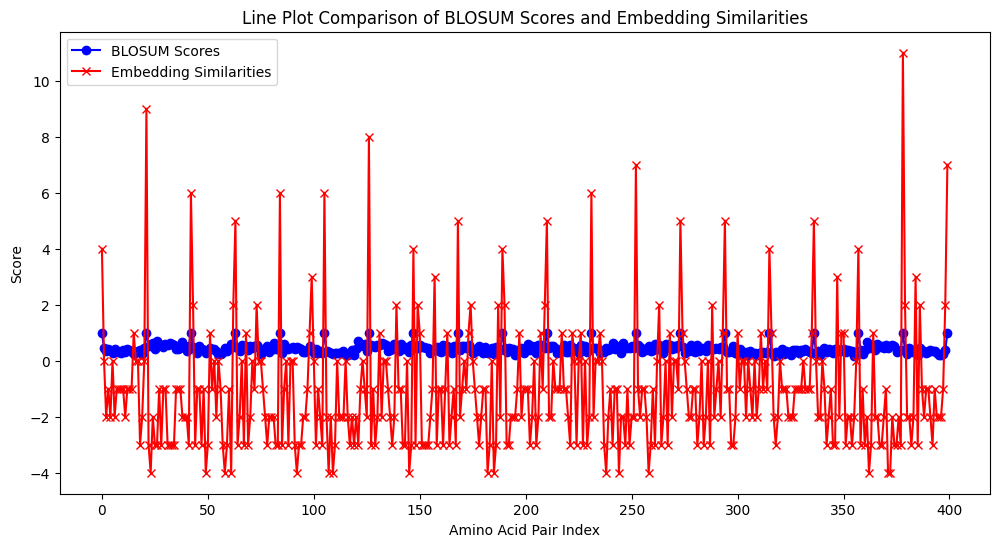

In [83]:
import matplotlib.pyplot as plt

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(blosum_scores, label='BLOSUM Scores', color='blue', marker='o')
plt.plot(embedding_similarities, label='Embedding Similarities', color='red', marker='x')
plt.title('Line Plot Comparison of BLOSUM Scores and Embedding Similarities')
plt.xlabel('Amino Acid Pair Index')
plt.ylabel('Score')
plt.legend()
plt.show()


## Blosum in UMAP

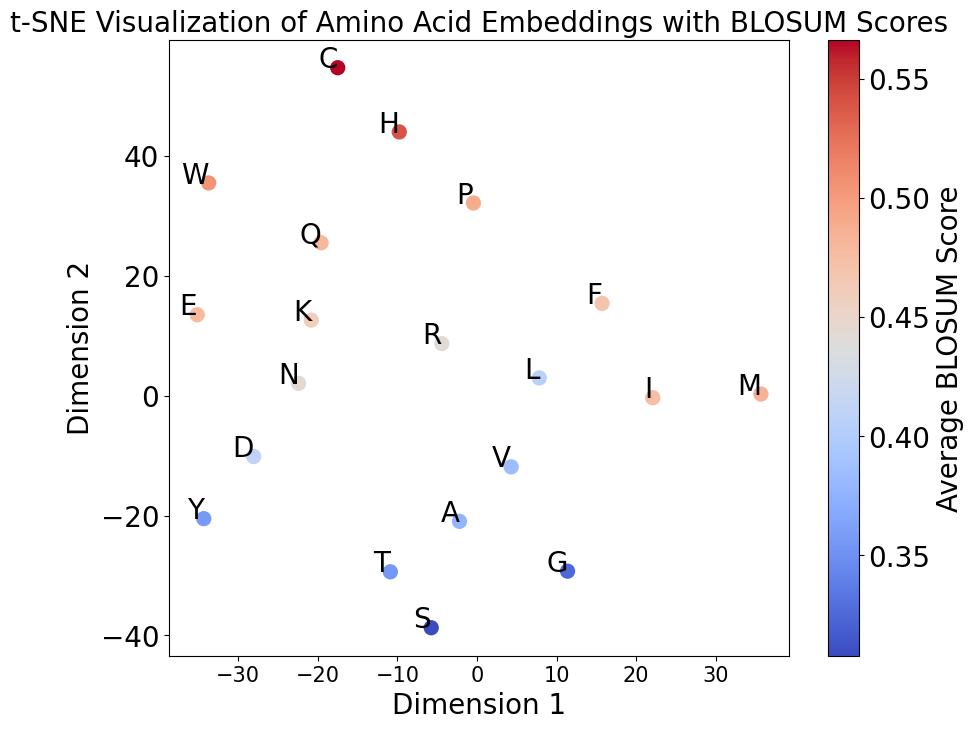

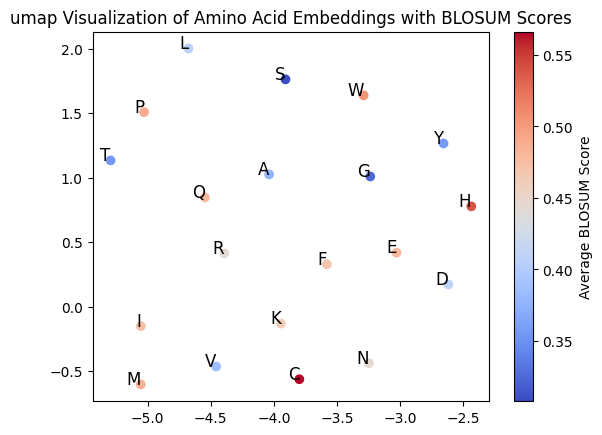

In [87]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming blosum_scores is already averaged for the 20 amino acids
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
average_blosum_scores = np.mean(blosum_scores.reshape(20,20), axis=0)
# Apply t-SNE
tsne_results = TSNE(n_components=2, random_state=42, perplexity=5,n_iter=3000).fit_transform(token_embeddings[5:])
umap_results = umap.UMAP(n_neighbors=5, min_dist=0.01, metric='cosine').fit_transform(token_embeddings[5:])

plt.figure(figsize=(10, 8))
# Plot the t-SNE results with average BLOSUM scores as color
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=average_blosum_scores, cmap='coolwarm',s=100)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Average BLOSUM Score', fontsize=20)

# Label each point with its corresponding amino acid
for i, amino_acid in enumerate(amino_acids):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], amino_acid, fontsize=20, ha='right')

plt.title('t-SNE Visualization of Amino Acid Embeddings with BLOSUM Scores',fontsize = 20)
plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=15)
plt.show()

plt.scatter(umap_results[:, 0], umap_results[:, 1], c=average_blosum_scores, cmap='coolwarm')
plt.colorbar(label='Average BLOSUM Score')

# Label each point with its corresponding amino acid
for i, amino_acid in enumerate(amino_acids):
    plt.text(umap_results[i, 0], umap_results[i, 1], amino_acid, fontsize=12, ha='right')

plt.title('umap Visualization of Amino Acid Embeddings with BLOSUM Scores')
plt.show()